## Set up

How to use XGBoost in RecSys
* Run your best algorithm and select a number of recommendations higher than the target cutoff, for example if you have to compute MAP@10, get 20 recommendations
* Build a dataframe whose samples are the user-item recommendations
* Add for each interaction some content features: item features, user features
* Add for each interaction some features derived by other algorithms: CBF prediction, hybrid prediction
* Add for each interaction other miscellaneous information: profile length, item popularity ..

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
from pathlib import Path
from typing import Union

import numpy as np
import pandas as pd
import polars as pl
import scipy.sparse as sps
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from xgboost import XGBRanker

from Data_manager.competition import load, load_raw
from Recommenders.BaseRecommender import BaseRecommender
from Recommenders.Similarity.Compute_Similarity import Compute_Similarity
from Recommenders.Hybrid import UserWideHybridRecommender, ScoresMultipleHybridRecommender

In [3]:
NUMBER_FOLDS = 10
CUTOFF = 10

In [4]:
MODELS_DIR = Path() / "models" / "train" / "map"
MODELS_DIR.exists()

True

In [5]:
TEST_ID_PATH = Path() / "Data_manager_split_datasets" / "competition" / "data_target_users_test.csv"
test_df = pd.read_csv(TEST_ID_PATH)
test_df

,user_id
0,0
1,1
2,2
3,3
4,4
...,...
34226,35729
34227,35730
34228,35731
34229,35734


In [6]:
SUBMISSION_PATH = Path("submission.csv")

In [7]:
icm_df, urm_df = load_raw()
number_users = urm_df["user_id"].nunique()
number_items = icm_df["item_id"].nunique()
print(number_users, number_items)

35736 38121


In [8]:
icm_matrix, urm_all, urm_train, urm_validation, urm_test = load()
ranker_urm = urm_validation + urm_test

### Helper functions

In [9]:
def encode_user_dicts(user_dicts: list[dict]) -> dict:
    return  {
        user_dict["UserID"]: user_dict["ItemID"][0]
        for user_dict in user_dicts
    }

In [10]:
def item_to_list() -> pl.Expr:
    return pl.col("ItemID").implode()

In [11]:
def decode_predictions(input_df: pd.DataFrame, model: XGBRanker, drop_ids: bool = False) -> dict[int, list]:
    output_df = input_df[["UserID", "ItemID"]].copy()
    if drop_ids:
        input_df = input_df.drop(columns=["UserID", "ItemID"])
    output_df["Score"] = model.predict(input_df)

    output_dicts = (
        pl.from_pandas(output_df)
        .group_by("UserID", "ItemID")
        .agg(pl.mean("Score"))
        .sort("UserID", "Score", descending=True)
        .group_by("UserID")
        .head(10)
        .group_by("UserID")
        .agg(item_to_list())
        .to_dicts()
    )
    return encode_user_dicts(output_dicts)

In [12]:
def decode_targets(input_df: pd.DataFrame, relevant_mask: pd.Series) -> dict[int, list]:
    return encode_user_dicts(
        pl.from_pandas(input_df[relevant_mask])
        .group_by("UserID")
        .agg(item_to_list())
        .to_dicts()
    )

In [13]:
def map_at_k(predictions: Union[dict[int, list], list[list]], true_labels: Union[dict[int, list], list[list]], k=10):
    """
    Compute Mean Average Precision at K (MAP@K).

    Parameters:
    - predictions: A list of lists, where each inner list contains the predicted item IDs for a user (ranked in descending order of relevance).
    - true_labels: A list of sets, where each set contains the ground-truth relevant item IDs for the corresponding user.
    - k: The cutoff for precision evaluation.

    Returns:
    - mean_ap: Mean Average Precision at K across all users.
    """
    def average_precision_at_k(predicted, actual, k):
        if len(predicted) > k:
            predicted = predicted[:k]

        score = 0.0
        num_hits = 0.0

        for i, p in enumerate(predicted):
            if p in actual and p not in predicted[:i]:  # Avoid duplicates
                num_hits += 1.0
                score += num_hits / (i + 1.0)

        if not actual:
            return 0.0

        return score / min(len(actual), k)

    if isinstance(predictions, list):
        predictions = {user: prediction for user, prediction in enumerate(predictions)}
    if isinstance(true_labels, list):
        true_labels = {user: true for user, true in enumerate(true_labels)}

    # Calculate AP@K for each user
    ap_scores = [
        average_precision_at_k(predictions[user], true, k)
        for user, true in true_labels.items()
    ]

    # Return the mean AP@K
    return np.mean(ap_scores)


## Data processing

### Candidate generation

#### Training

In [37]:
USER_WIDE_HYBRID_BEGIN = 30
MODELS_TO_USE = (
    60,
    61,
    62,
    63,
)

In [38]:
NUMBER_GROUPS_USER_WIDE_HYBRID = 10
MULTIPLE_SCORE_HYBRID_WEIGHTS = {
    50: 0.253770701546336,
    51: 0.10324855050317669,
}


def build_user_wide_hybrid(urm: sps.csr_matrix, models: dict[str, BaseRecommender]):
    profile_lengths = np.ediff1d(urm.indptr)
    sorted_users = np.argsort(profile_lengths)
    block_size = len(sorted_users) // NUMBER_GROUPS_USER_WIDE_HYBRID
    group_users = {}
    for group in range(NUMBER_GROUPS_USER_WIDE_HYBRID + 1):
        group_users[group] = sorted_users[group * block_size : (group + 1) * block_size]
    group_recommenders = {
        group: models.pop(str(USER_WIDE_HYBRID_BEGIN + group)) for group in range(NUMBER_GROUPS_USER_WIDE_HYBRID + 1)
    }
    return UserWideHybridRecommender(urm, group_users, group_recommenders)

def build_score_hybrid(urm: sps.csr_matrix, models: dict[str, BaseRecommender]):
    recommenders = [models.pop(str(index)) for index in MULTIPLE_SCORE_HYBRID_WEIGHTS.keys()]
    weights = list(MULTIPLE_SCORE_HYBRID_WEIGHTS.values())
    return ScoresMultipleHybridRecommender(urm, recommenders, weights)

In [39]:
fold_training_dataframes: dict[int, pd.DataFrame] = {}
for i, (train_indices, val_indices) in tqdm(
    enumerate(KFold(NUMBER_FOLDS, shuffle=True, random_state=42).split(urm_df)),
    total=NUMBER_FOLDS,
    desc="Fold",
):
    fold_urm_train_df = urm_df.iloc[train_indices]
    fold_urm_train  = sps.csr_matrix(
        (fold_urm_train_df.data, (fold_urm_train_df.user_id, fold_urm_train_df.item_id)),
        shape=(number_users, number_items),
    )

    fold_models_dir = MODELS_DIR / str(i)
    models: dict[str, BaseRecommender] = {
        path.stem: pickle.load(path.open("rb"))
        for path in fold_models_dir.glob("*.pkl")
    }
    if "user_wide_hybrid" not in models:
        fold_user_wide_hybrid = build_user_wide_hybrid(fold_urm_train, models)
    # if "score_hybrid" not in models:
    #     fold_score_hybrid = build_score_hybrid(fold_urm_train, models)

    models = {str(index): models[str(index)] for index in MODELS_TO_USE}
    if "user_wide_hybrid" not in models:
        models["user_wide_hybrid"] = fold_user_wide_hybrid
    # if "score_hybrid" not in models:
    #     models["score_hybrid"] = fold_score_hybrid

    training_dataframe = pd.DataFrame(index=range(0, number_users), columns=["ItemID"])
    training_dataframe.index.name = "UserID"

    recommendations_list = []
    recommenders_list = []
    rank_list = []
    for user_id in tqdm(range(number_users), desc="User (candidate)"):
        user_recommendations = []
        user_recommenders = []
        user_rankings = []
        for name, recommender in models.items():
            user_recommendations.extend(
                recommender.recommend(
                    user_id,
                    cutoff=CUTOFF,
                    remove_seen_flag=True,
                )
            )
            user_recommenders.extend([name] * CUTOFF)
            user_rankings.extend(list(range(CUTOFF)))
        recommendations_list.append(user_recommendations)
        recommenders_list.append(user_recommenders)
        rank_list.append(user_rankings)

    training_dataframe["ItemID"] = recommendations_list
    training_dataframe["Recommender"] = recommenders_list
    training_dataframe["Ranking"] = rank_list

    exploded_recommender = training_dataframe["Recommender"].explode()
    exploded_ranking = training_dataframe["Ranking"].explode()
    training_dataframe = training_dataframe.explode("ItemID")
    training_dataframe["Recommender"] = exploded_recommender
    training_dataframe["Ranking"] = exploded_ranking.astype("int")

    recommender_agreement = (
        training_dataframe.reset_index()[["UserID", "ItemID"]]
        .groupby(["UserID", "ItemID"])
        .value_counts()
    )
    training_dataframe["recommender_agreement"] = recommender_agreement.loc[
        list(zip(training_dataframe.index, training_dataframe["ItemID"]))
    ].to_numpy()

    fold_urm_val_df = urm_df.iloc[val_indices]
    fold_urm_val  = sps.csr_matrix(
        (fold_urm_val_df.data, (fold_urm_val_df.user_id, fold_urm_val_df.item_id)),
        shape=(number_users, number_items),
    )
    fold_urm_coo = sps.coo_matrix(fold_urm_val)
    correct_recommendations = pd.DataFrame(
        {"UserID": fold_urm_coo.row, "ItemID": fold_urm_coo.col}
    )
    training_dataframe = training_dataframe.merge(
        correct_recommendations,
        on=["UserID", "ItemID"],
        how="left",
        indicator="Exist",
    )
    training_dataframe["Label"] = training_dataframe["Exist"] == "both"
    training_dataframe = training_dataframe.drop(columns=["Exist"])

    training_dataframe = training_dataframe.set_index("UserID")
    for user_id in tqdm(training_dataframe.index.unique(), desc="User (score)"):
        for rec_label, rec_instance in models.items():
            item_list = training_dataframe.loc[user_id, "ItemID"].to_list()

            all_item_scores = rec_instance._compute_item_score(
                [user_id], items_to_compute=item_list
            )

            training_dataframe.loc[user_id, rec_label] = all_item_scores[0, item_list]

    training_dataframe = training_dataframe.reset_index()
    training_dataframe = training_dataframe.rename(columns={"index": "UserID"})

    training_dataframe["fold"] = i
    fold_training_dataframes[i] = training_dataframe

Fold:   0%|          | 0/10 [00:00<?, ?it/s]

/home/tomaz/git/Politecnico/Subjects/recommender-systems/recsys-competition/.venv/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator ElasticNet from version 1.6.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


User (candidate):   0%|          | 0/35736 [00:00<?, ?it/s]

User (score):   0%|          | 0/35736 [00:00<?, ?it/s]

/home/tomaz/git/Politecnico/Subjects/recommender-systems/recsys-competition/.venv/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator ElasticNet from version 1.6.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


User (candidate):   0%|          | 0/35736 [00:00<?, ?it/s]

User (score):   0%|          | 0/35736 [00:00<?, ?it/s]

/home/tomaz/git/Politecnico/Subjects/recommender-systems/recsys-competition/.venv/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator ElasticNet from version 1.6.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


User (candidate):   0%|          | 0/35736 [00:00<?, ?it/s]

User (score):   0%|          | 0/35736 [00:00<?, ?it/s]

/home/tomaz/git/Politecnico/Subjects/recommender-systems/recsys-competition/.venv/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator ElasticNet from version 1.6.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


User (candidate):   0%|          | 0/35736 [00:00<?, ?it/s]

User (score):   0%|          | 0/35736 [00:00<?, ?it/s]

/home/tomaz/git/Politecnico/Subjects/recommender-systems/recsys-competition/.venv/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator ElasticNet from version 1.6.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


User (candidate):   0%|          | 0/35736 [00:00<?, ?it/s]

User (score):   0%|          | 0/35736 [00:00<?, ?it/s]

/home/tomaz/git/Politecnico/Subjects/recommender-systems/recsys-competition/.venv/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator ElasticNet from version 1.6.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


User (candidate):   0%|          | 0/35736 [00:00<?, ?it/s]

User (score):   0%|          | 0/35736 [00:00<?, ?it/s]

/home/tomaz/git/Politecnico/Subjects/recommender-systems/recsys-competition/.venv/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator ElasticNet from version 1.6.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


User (candidate):   0%|          | 0/35736 [00:00<?, ?it/s]

User (score):   0%|          | 0/35736 [00:00<?, ?it/s]

/home/tomaz/git/Politecnico/Subjects/recommender-systems/recsys-competition/.venv/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator ElasticNet from version 1.6.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


User (candidate):   0%|          | 0/35736 [00:00<?, ?it/s]

User (score):   0%|          | 0/35736 [00:00<?, ?it/s]

/home/tomaz/git/Politecnico/Subjects/recommender-systems/recsys-competition/.venv/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator ElasticNet from version 1.6.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


User (candidate):   0%|          | 0/35736 [00:00<?, ?it/s]

User (score):   0%|          | 0/35736 [00:00<?, ?it/s]

/home/tomaz/git/Politecnico/Subjects/recommender-systems/recsys-competition/.venv/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator ElasticNet from version 1.6.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


User (candidate):   0%|          | 0/35736 [00:00<?, ?it/s]

User (score):   0%|          | 0/35736 [00:00<?, ?it/s]

In [40]:
training_dataframe = pd.concat(fold_training_dataframes.values())
training_dataframe

,UserID,ItemID,Recommender,Ranking,recommender_agreement,Label,60,61,62,63,user_wide_hybrid,fold
0,0,7703,60,0,4,False,0.268031,0.401745,2.693894,0.085774,0.272271,0
1,0,7547,60,1,4,False,0.258316,0.352410,2.404292,0.066998,0.265295,0
2,0,6822,60,2,3,True,0.237978,0.143136,0.850208,0.182649,0.221734,0
3,0,572,60,3,5,False,0.234505,0.300062,1.903718,0.160482,0.222038,0
4,0,3077,60,4,4,True,0.234102,0.241273,1.361896,0.182695,0.232855,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1786795,35735,37445,user_wide_hybrid,5,5,False,0.343499,0.630422,4.550226,0.199559,0.353038,9
1786796,35735,37507,user_wide_hybrid,6,2,False,0.313335,0.395291,1.350077,0.171390,0.333600,9
1786797,35735,36775,user_wide_hybrid,7,5,False,0.326151,0.581158,3.998512,0.191833,0.327440,9
1786798,35735,34998,user_wide_hybrid,8,2,False,0.326401,0.430699,2.925698,0.127431,0.326283,9


#### Submission

In [21]:
submit_models_dir = Path() / "models" / "all" / "map" / "0"
models: dict[str, BaseRecommender] = {
    path.stem: pickle.load(path.open("rb"))
    for path in submit_models_dir.glob("*.pkl")
}

submission_dataframe = pd.DataFrame(index=range(0, number_users), columns=["ItemID"])
submission_dataframe.index.name = "UserID"

recommendations_list = []
recommenders_list = []
rank_list = []
for user_id in tqdm(range(number_users), desc="User (candidate)"):
    user_recommendations = []
    user_recommenders = []
    user_rankings = []
    for name, recommender in models.items():
        user_recommendations.extend(
            recommender.recommend(
                user_id,
                cutoff=CUTOFF,
                remove_seen_flag=True,
            )
        )
        user_recommenders.extend([name] * CUTOFF)
        user_rankings.extend(list(range(CUTOFF)))
    recommendations_list.append(user_recommendations)
    recommenders_list.append(user_recommenders)
    rank_list.append(user_rankings)

submission_dataframe["ItemID"] = recommendations_list
submission_dataframe["Recommender"] = recommenders_list
submission_dataframe["Ranking"] = rank_list

exploded_recommender = submission_dataframe["Recommender"].explode()
exploded_ranking = submission_dataframe["Ranking"].explode()
submission_dataframe = submission_dataframe.explode("ItemID")
submission_dataframe["Recommender"] = exploded_recommender
submission_dataframe["Ranking"] = exploded_ranking.astype("int")

recommender_agreement = (
    submission_dataframe.reset_index()[["UserID", "ItemID"]]
    .groupby(["UserID", "ItemID"])
    .value_counts()
)
submission_dataframe["recommender_agreement"] = recommender_agreement.loc[
    list(zip(submission_dataframe.index, submission_dataframe["ItemID"]))
].to_numpy()


for user_id in tqdm(submission_dataframe.index.unique(), desc="User (score)"):
    for rec_label, rec_instance in models.items():
        item_list = submission_dataframe.loc[user_id, "ItemID"].to_list()

        all_item_scores = rec_instance._compute_item_score(
            [user_id], items_to_compute=item_list
        )

        submission_dataframe.loc[user_id, rec_label] = all_item_scores[0, item_list]

submission_dataframe = submission_dataframe.reset_index()
submission_dataframe = submission_dataframe.rename(columns={"index": "UserID"})
submission_dataframe

User (candidate):   0%|          | 0/35736 [00:00<?, ?it/s]

User (score):   0%|          | 0/35736 [00:00<?, ?it/s]

,UserID,ItemID,Recommender,Ranking,recommender_agreement,23,21,22,20,user_wide_hybrid
0,0,572,23,0,4,3.708066,0.364245,0.184505,0.906074,0.288273
1,0,14888,23,1,4,3.389925,0.282408,0.327246,1.195710,0.312018
2,0,452,23,2,1,3.183915,0.180780,0.072435,0.279713,0.242547
3,0,9911,23,3,2,2.940626,0.226980,0.315740,1.171455,0.176901
4,0,14931,23,4,1,2.921493,0.238371,0.189480,0.695994,0.246573
...,...,...,...,...,...,...,...,...,...,...
1786795,35735,36775,user_wide_hybrid,5,3,8.471791,0.328802,0.358924,2.157352,0.664134
1786796,35735,37660,user_wide_hybrid,6,3,7.323517,0.347563,0.192113,1.368214,0.588393
1786797,35735,36920,user_wide_hybrid,7,3,7.601600,0.342447,0.263019,1.772518,0.581799
1786798,35735,37017,user_wide_hybrid,8,2,4.652850,0.303232,0.303558,2.394336,0.573921


In [22]:
training_dataframe = submission_dataframe
training_dataframe

,UserID,ItemID,Recommender,Ranking,recommender_agreement,23,21,22,20,user_wide_hybrid
0,0,572,23,0,4,3.708066,0.364245,0.184505,0.906074,0.288273
1,0,14888,23,1,4,3.389925,0.282408,0.327246,1.195710,0.312018
2,0,452,23,2,1,3.183915,0.180780,0.072435,0.279713,0.242547
3,0,9911,23,3,2,2.940626,0.226980,0.315740,1.171455,0.176901
4,0,14931,23,4,1,2.921493,0.238371,0.189480,0.695994,0.246573
...,...,...,...,...,...,...,...,...,...,...
1786795,35735,36775,user_wide_hybrid,5,3,8.471791,0.328802,0.358924,2.157352,0.664134
1786796,35735,37660,user_wide_hybrid,6,3,7.323517,0.347563,0.192113,1.368214,0.588393
1786797,35735,36920,user_wide_hybrid,7,3,7.601600,0.342447,0.263019,1.772518,0.581799
1786798,35735,37017,user_wide_hybrid,8,2,4.652850,0.303232,0.303558,2.394336,0.573921


### Item features

#### Item popularity

In [16]:
item_popularity = np.ediff1d(sps.csc_matrix(urm_all).indptr)

In [17]:
training_dataframe["item_popularity"] = item_popularity[
    training_dataframe["ItemID"].to_numpy().astype(int)
]
training_dataframe

,UserID,ItemID,Recommender,Ranking,recommender_agreement,Label,23,21,22,20,user_wide_hybrid,fold,item_popularity,item_similarity,user_profile_len,top_10,top_100,top_1000,user_similarity
0,0,11919,user_wide_hybrid,4,4,False,2.036243,0.185144,0.457867,0.898495,0.279088,0,29,0.010543,114,0.0,1.0,7.0,0.000183
1,0,6166,user_wide_hybrid,5,2,False,1.322843,0.142692,0.410831,0.314082,0.275740,0,129,0.000371,114,0.0,1.0,7.0,0.000183
2,0,572,23,0,3,False,3.110688,0.239450,0.206285,0.740719,0.144743,0,93,0.000246,114,0.0,1.0,7.0,0.000183
3,0,14888,23,1,3,False,2.772010,0.219615,0.148456,0.641081,0.263636,0,110,0.000250,114,0.0,1.0,7.0,0.000183
4,0,3055,23,2,2,False,2.486904,0.125511,0.207595,0.236244,0.265044,0,93,0.001264,114,0.0,1.0,7.0,0.000183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17867995,35735,37017,22,2,3,False,5.954237,0.231383,0.389701,1.841514,0.552304,6,58,0.003902,37,0.0,0.0,0.0,0.000272
17867996,35735,36034,23,0,5,False,10.295866,0.404087,0.471801,2.180797,1.575182,9,81,0.000403,37,0.0,0.0,0.0,0.000272
17867997,35735,36266,user_wide_hybrid,6,4,True,4.560175,0.319728,0.326213,1.904749,0.555987,6,20,0.001241,37,0.0,0.0,0.0,0.000272
17867998,35735,37800,user_wide_hybrid,4,3,True,6.373811,0.285733,0.520935,1.544810,1.246396,9,76,0.003428,37,0.0,0.0,0.0,0.000272


#### Distance to closest items

In [25]:
item_similarity = Compute_Similarity(icm_matrix.T).compute_similarity()
item_similarity

Similarity column 38121 (100.0%), 984.42 column/sec. Elapsed time 38.72 sec


<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 3812100 stored elements and shape (38121, 38121)>

In [26]:
mean_item_similarity_dict = {i: row.mean() for i, row in enumerate(item_similarity)}
mean_item_similarity: pd.DataFrame = pd.Series(mean_item_similarity_dict).to_frame(name="item_similarity")
mean_item_similarity

,item_similarity
0,0.000046
1,0.000309
2,0.000140
3,0.000105
4,0.000015
...,...
38116,0.000397
38117,0.007546
38118,0.005463
38119,0.000602


In [27]:
training_dataframe = training_dataframe.join(mean_item_similarity, on="ItemID")
training_dataframe

,UserID,ItemID,Recommender,Ranking,recommender_agreement,23,21,22,20,user_wide_hybrid,item_popularity,item_similarity
0,0,572,23,0,4,3.708066,0.364245,0.184505,0.906074,0.288273,93,0.000246
1,0,14888,23,1,4,3.389925,0.282408,0.327246,1.195710,0.312018,110,0.000250
2,0,452,23,2,1,3.183915,0.180780,0.072435,0.279713,0.242547,120,0.000545
3,0,9911,23,3,2,2.940626,0.226980,0.315740,1.171455,0.176901,27,0.000040
4,0,14931,23,4,1,2.921493,0.238371,0.189480,0.695994,0.246573,107,0.000224
...,...,...,...,...,...,...,...,...,...,...,...,...
1786795,35735,36775,user_wide_hybrid,5,3,8.471791,0.328802,0.358924,2.157352,0.664134,88,0.003954
1786796,35735,37660,user_wide_hybrid,6,3,7.323517,0.347563,0.192113,1.368214,0.588393,70,0.003902
1786797,35735,36920,user_wide_hybrid,7,3,7.601600,0.342447,0.263019,1.772518,0.581799,147,0.003986
1786798,35735,37017,user_wide_hybrid,8,2,4.652850,0.303232,0.303558,2.394336,0.573921,58,0.003902


### User features

#### User popularity

In [28]:
user_popularity = np.ediff1d(sps.csr_matrix(urm_all).indptr)

In [29]:
training_dataframe["user_profile_len"] = user_popularity[
    training_dataframe["UserID"].to_numpy().astype(int)
]
training_dataframe

,UserID,ItemID,Recommender,Ranking,recommender_agreement,23,21,22,20,user_wide_hybrid,item_popularity,item_similarity,user_profile_len
0,0,572,23,0,4,3.708066,0.364245,0.184505,0.906074,0.288273,93,0.000246,114
1,0,14888,23,1,4,3.389925,0.282408,0.327246,1.195710,0.312018,110,0.000250,114
2,0,452,23,2,1,3.183915,0.180780,0.072435,0.279713,0.242547,120,0.000545,114
3,0,9911,23,3,2,2.940626,0.226980,0.315740,1.171455,0.176901,27,0.000040,114
4,0,14931,23,4,1,2.921493,0.238371,0.189480,0.695994,0.246573,107,0.000224,114
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1786795,35735,36775,user_wide_hybrid,5,3,8.471791,0.328802,0.358924,2.157352,0.664134,88,0.003954,37
1786796,35735,37660,user_wide_hybrid,6,3,7.323517,0.347563,0.192113,1.368214,0.588393,70,0.003902,37
1786797,35735,36920,user_wide_hybrid,7,3,7.601600,0.342447,0.263019,1.772518,0.581799,147,0.003986,37
1786798,35735,37017,user_wide_hybrid,8,2,4.652850,0.303232,0.303558,2.394336,0.573921,58,0.003902,37


#### User popularity bias

Measure of how much popularity influences the user

In [30]:
item_popularity_ranking = item_popularity.argsort()[::-1]
item_popularity_ranking

array([11146, 25392,  4601, ...,  8491, 21675,  8152])

In [31]:
item_id_df = urm_df[["user_id", "item_id"]]
item_id_df

,user_id,item_id
0,0,0
1,0,2
2,0,120
3,0,128
4,0,211
...,...,...
1764602,35735,37802
1764603,35735,37803
1764604,35735,37805
1764605,35735,38000


In [32]:
TOP_POPULAR_THRESHOLDS = (10, 100, 1000)

In [33]:
for k in TOP_POPULAR_THRESHOLDS:
    top_k_popular = item_popularity_ranking[:k]
    item_id_df.loc[item_id_df["item_id"].isin(top_k_popular), f"top_{k}"] = 1
item_id_df = item_id_df.fillna(0)
item_id_df

,user_id,item_id,top_10,top_100,top_1000
0,0,0,0.0,0.0,0.0
1,0,2,0.0,0.0,0.0
2,0,120,0.0,0.0,0.0
3,0,128,0.0,0.0,0.0
4,0,211,0.0,0.0,1.0
...,...,...,...,...,...
1764602,35735,37802,0.0,0.0,0.0
1764603,35735,37803,0.0,0.0,0.0
1764604,35735,37805,0.0,0.0,0.0
1764605,35735,38000,0.0,0.0,0.0


In [34]:
user_top_k_df = item_id_df.groupby("user_id").aggregate({f"top_{k}": "sum" for k in TOP_POPULAR_THRESHOLDS})
user_top_k_df

,top_10,top_100,top_1000
user_id,,,
0,0.0,1.0,7.0
1,2.0,3.0,10.0
2,0.0,0.0,0.0
3,1.0,4.0,11.0
4,0.0,3.0,29.0
...,...,...,...
35731,0.0,0.0,0.0
35732,0.0,0.0,1.0
35733,0.0,0.0,0.0


In [35]:
training_dataframe = training_dataframe.join(user_top_k_df, on="UserID")
training_dataframe

,UserID,ItemID,Recommender,Ranking,recommender_agreement,23,21,22,20,user_wide_hybrid,item_popularity,item_similarity,user_profile_len,top_10,top_100,top_1000
0,0,572,23,0,4,3.708066,0.364245,0.184505,0.906074,0.288273,93,0.000246,114,0.0,1.0,7.0
1,0,14888,23,1,4,3.389925,0.282408,0.327246,1.195710,0.312018,110,0.000250,114,0.0,1.0,7.0
2,0,452,23,2,1,3.183915,0.180780,0.072435,0.279713,0.242547,120,0.000545,114,0.0,1.0,7.0
3,0,9911,23,3,2,2.940626,0.226980,0.315740,1.171455,0.176901,27,0.000040,114,0.0,1.0,7.0
4,0,14931,23,4,1,2.921493,0.238371,0.189480,0.695994,0.246573,107,0.000224,114,0.0,1.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1786795,35735,36775,user_wide_hybrid,5,3,8.471791,0.328802,0.358924,2.157352,0.664134,88,0.003954,37,0.0,0.0,0.0
1786796,35735,37660,user_wide_hybrid,6,3,7.323517,0.347563,0.192113,1.368214,0.588393,70,0.003902,37,0.0,0.0,0.0
1786797,35735,36920,user_wide_hybrid,7,3,7.601600,0.342447,0.263019,1.772518,0.581799,147,0.003986,37,0.0,0.0,0.0
1786798,35735,37017,user_wide_hybrid,8,2,4.652850,0.303232,0.303558,2.394336,0.573921,58,0.003902,37,0.0,0.0,0.0


#### Distance to closest users

In [36]:
user_similarity = Compute_Similarity(urm_all.T).compute_similarity()
user_similarity

Similarity column 35736 (100.0%), 6092.46 column/sec. Elapsed time 5.87 sec


<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 3573591 stored elements and shape (35736, 35736)>

In [37]:
mean_user_similarity_dict = {i: row.mean() for i, row in enumerate(user_similarity)}
mean_user_similarity: pd.DataFrame = pd.Series(mean_user_similarity_dict).to_frame(name="user_similarity")
mean_user_similarity

,user_similarity
0,0.000183
1,0.000357
2,0.000161
3,0.000158
4,0.001004
...,...
35731,0.000204
35732,0.000333
35733,0.000267
35734,0.000341


In [38]:
training_dataframe = training_dataframe.join(mean_user_similarity, on="UserID")
training_dataframe

,UserID,ItemID,Recommender,Ranking,recommender_agreement,23,21,22,20,user_wide_hybrid,item_popularity,item_similarity,user_profile_len,top_10,top_100,top_1000,user_similarity
0,0,572,23,0,4,3.708066,0.364245,0.184505,0.906074,0.288273,93,0.000246,114,0.0,1.0,7.0,0.000183
1,0,14888,23,1,4,3.389925,0.282408,0.327246,1.195710,0.312018,110,0.000250,114,0.0,1.0,7.0,0.000183
2,0,452,23,2,1,3.183915,0.180780,0.072435,0.279713,0.242547,120,0.000545,114,0.0,1.0,7.0,0.000183
3,0,9911,23,3,2,2.940626,0.226980,0.315740,1.171455,0.176901,27,0.000040,114,0.0,1.0,7.0,0.000183
4,0,14931,23,4,1,2.921493,0.238371,0.189480,0.695994,0.246573,107,0.000224,114,0.0,1.0,7.0,0.000183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1786795,35735,36775,user_wide_hybrid,5,3,8.471791,0.328802,0.358924,2.157352,0.664134,88,0.003954,37,0.0,0.0,0.0,0.000272
1786796,35735,37660,user_wide_hybrid,6,3,7.323517,0.347563,0.192113,1.368214,0.588393,70,0.003902,37,0.0,0.0,0.0,0.000272
1786797,35735,36920,user_wide_hybrid,7,3,7.601600,0.342447,0.263019,1.772518,0.581799,147,0.003986,37,0.0,0.0,0.0,0.000272
1786798,35735,37017,user_wide_hybrid,8,2,4.652850,0.303232,0.303558,2.394336,0.573921,58,0.003902,37,0.0,0.0,0.0,0.000272


### Conversion to categories

In [39]:
training_dataframe = training_dataframe.sort_values("UserID").reset_index(drop=True)
training_dataframe

,UserID,ItemID,Recommender,Ranking,recommender_agreement,23,21,22,20,user_wide_hybrid,item_popularity,item_similarity,user_profile_len,top_10,top_100,top_1000,user_similarity
0,0,6166,user_wide_hybrid,7,2,0.000000,0.142024,0.421410,0.353835,0.270525,129,0.000371,114,0.0,1.0,7.0,0.000183
1,0,11966,user_wide_hybrid,6,1,0.000000,0.145097,0.267107,0.893614,0.283992,52,0.000568,114,0.0,1.0,7.0,0.000183
2,0,2743,user_wide_hybrid,5,1,1.452733,0.195061,0.273309,0.521364,0.284803,39,0.000069,114,0.0,1.0,7.0,0.000183
3,0,2637,22,8,1,0.000000,0.197307,0.381694,0.790003,0.218590,67,0.000177,114,0.0,1.0,7.0,0.000183
4,0,738,22,9,1,1.694155,0.103107,0.370141,0.318969,0.093946,29,0.000474,114,0.0,1.0,7.0,0.000183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1786795,35735,36775,user_wide_hybrid,5,3,8.471791,0.328802,0.358924,2.157352,0.664134,88,0.003954,37,0.0,0.0,0.0,0.000272
1786796,35735,37445,user_wide_hybrid,4,5,7.411239,0.408742,0.455056,3.137702,0.680556,27,0.000132,37,0.0,0.0,0.0,0.000272
1786797,35735,36917,user_wide_hybrid,3,5,8.380329,0.453475,0.383239,2.259961,0.839466,76,0.004296,37,0.0,0.0,0.0,0.000272
1786798,35735,36034,user_wide_hybrid,2,5,10.576296,0.430645,0.403139,2.485576,1.015675,81,0.000403,37,0.0,0.0,0.0,0.000272


In [40]:
training_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1786800 entries, 0 to 1786799
Data columns (total 17 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   UserID                 int64  
 1   ItemID                 object 
 2   Recommender            object 
 3   Ranking                int64  
 4   recommender_agreement  int64  
 5   23                     float32
 6   21                     float32
 7   22                     float32
 8   20                     float32
 9   user_wide_hybrid       float32
 10  item_popularity        int32  
 11  item_similarity        float32
 12  user_profile_len       int32  
 13  top_10                 float64
 14  top_100                float64
 15  top_1000               float64
 16  user_similarity        float32
dtypes: float32(7), float64(3), int32(2), int64(3), object(2)
memory usage: 170.4+ MB


In [41]:
training_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1786800 entries, 0 to 1786799
Data columns (total 17 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   UserID                 int64  
 1   ItemID                 object 
 2   Recommender            object 
 3   Ranking                int64  
 4   recommender_agreement  int64  
 5   23                     float32
 6   21                     float32
 7   22                     float32
 8   20                     float32
 9   user_wide_hybrid       float32
 10  item_popularity        int32  
 11  item_similarity        float32
 12  user_profile_len       int32  
 13  top_10                 float64
 14  top_100                float64
 15  top_1000               float64
 16  user_similarity        float32
dtypes: float32(7), float64(3), int32(2), int64(3), object(2)
memory usage: 170.4+ MB


In [42]:
categorical_training_dataframe = training_dataframe
for categorical_column in ("UserID", "ItemID", "Recommender"):
    categorical_training_dataframe[categorical_column] = categorical_training_dataframe[categorical_column].astype("category")
categorical_training_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1786800 entries, 0 to 1786799
Data columns (total 17 columns):
 #   Column                 Dtype   
---  ------                 -----   
 0   UserID                 category
 1   ItemID                 category
 2   Recommender            category
 3   Ranking                int64   
 4   recommender_agreement  int64   
 5   23                     float32 
 6   21                     float32 
 7   22                     float32 
 8   20                     float32 
 9   user_wide_hybrid       float32 
 10  item_popularity        int32   
 11  item_similarity        float32 
 12  user_profile_len       int32   
 13  top_10                 float64 
 14  top_100                float64 
 15  top_1000               float64 
 16  user_similarity        float32 
dtypes: category(3), float32(7), float64(3), int32(2), int64(2)
memory usage: 144.0 MB


### Save

In [61]:
categorical_training_dataframe.to_parquet("ranker_training_data_2_no_score.parquet")

## Ranker pre-processing

### Load

In [14]:
categorical_training_dataframe = pd.read_parquet("ranker_training_data_statistics.parquet")
categorical_training_dataframe

### Train-val split

In [15]:
fold = categorical_training_dataframe.pop("fold")

train_df = categorical_training_dataframe[fold != 9]
y_train = train_df["Label"]
X_train = train_df.drop(columns="Label")

val_df = categorical_training_dataframe[fold == 9]
y_val = val_df["Label"]
X_val = val_df.drop(columns="Label")

To use the ranker one first needs to specify the size of the groups, a group is the dimension you rank on, in this case each group corresponds to a user. Since we have generated a fixed number of candidates for each user, all groups have the same length.

In [16]:
train_groups = X_train.groupby("UserID").size().to_numpy()
val_groups = X_val.groupby("UserID").size().to_numpy()

print(train_groups.shape, val_groups.shape)

(35736,) (35736,)


In [17]:
for y in (y_train, y_val):
    print(pd.Series(y_train).value_counts(normalize=True))

False    0.941629
True     0.058371
Name: Label, dtype: float64
False    0.941629
True     0.058371
Name: Label, dtype: float64


In [18]:
for X in (X_train, X_val):
    print(X.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19297440 entries, 0 to 2144159
Data columns (total 24 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   UserID                  int64   
 1   ItemID                  int64   
 2   Recommender             category
 3   Ranking                 int64   
 4   recommender_agreement   int64   
 5   score_20                float32 
 6   score_21                float32 
 7   score_22                float32 
 8   score_23                float32 
 9   score_user_wide_hybrid  float32 
 10  score_score_hybrid      float32 
 11  score_mean              float32 
 12  score_std               float32 
 13  score_min               float32 
 14  score_max               float32 
 15  score_kurtosis          float32 
 16  score_skew              float64 
 17  item_popularity         int32   
 18  item_similarity         float32 
 19  user_profile_len        int32   
 20  top_10                  float64 
 21  top_100

## Train

In [19]:
BEST_XGB_RANKER = {
    # Fixed parameters
    "enable_categorical": True,
    "random_state": 42,
    "objective": "rank:pairwise",
    "eval_metric": "map@10",
    "early_stopping_rounds": 10,  # Early stopping patience
    # Optimised parameters
    "learning_rate": 0.021791864322986187,
    "n_estimators": 79,
    "max_depth": 10,
    "reg_alpha": 0.06351745398607728,  # L1 regularisation
    "reg_lambda": 0.7509535138381521,  # L2 regularisation
    "subsample": 0.628614024512387,
    "colsample_bytree": 0.6104118118708399,
}

XGB_model = XGBRanker(**BEST_XGB_RANKER)

In [20]:
XGB_model.fit(
    X_train,  # .drop(columns=["UserID", "ItemID"]),
    y_train,
    group=train_groups,
    eval_set=[(X_val, y_val)],
    eval_group=[val_groups],
    verbose=True,
)

[0]	validation_0-map@10:0.56641
[1]	validation_0-map@10:0.58357
[2]	validation_0-map@10:0.59015
[3]	validation_0-map@10:0.59280
[4]	validation_0-map@10:0.59434
[5]	validation_0-map@10:0.59573
[6]	validation_0-map@10:0.59704
[7]	validation_0-map@10:0.59770
[8]	validation_0-map@10:0.59841
[9]	validation_0-map@10:0.59921
[10]	validation_0-map@10:0.59953
[11]	validation_0-map@10:0.60004
[12]	validation_0-map@10:0.60071
[13]	validation_0-map@10:0.60114
[14]	validation_0-map@10:0.60116
[15]	validation_0-map@10:0.60160
[16]	validation_0-map@10:0.60187
[17]	validation_0-map@10:0.60206
[18]	validation_0-map@10:0.60218
[19]	validation_0-map@10:0.60217
[20]	validation_0-map@10:0.60212
[21]	validation_0-map@10:0.60235
[22]	validation_0-map@10:0.60257
[23]	validation_0-map@10:0.60262
[24]	validation_0-map@10:0.60309
[25]	validation_0-map@10:0.60300
[26]	validation_0-map@10:0.60297
[27]	validation_0-map@10:0.60290
[28]	validation_0-map@10:0.60308
[29]	validation_0-map@10:0.60340
[30]	validation_0-ma

XGBRanker(base_score=None, booster=None, callbacks=None, colsample_bylevel=None,
          colsample_bynode=None, colsample_bytree=0.6104118118708399,
          device=None, early_stopping_rounds=10, enable_categorical=True,
          eval_metric='map@10', feature_types=None, gamma=None,
          grow_policy=None, importance_type=None, interaction_constraints=None,
          learning_rate=0.021791864322986187, max_bin=None,
          max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None,
          max_depth=10, max_leaves=None, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=79,
          n_jobs=None, num_parallel_tree=None, objective='rank:pairwise', ...)

## Evaluate

### Model metrics

In [32]:
XGB_model.score(
    X_train,  # .drop(columns=["UserID", "ItemID"]),
    y_train,
)

1.0

In [33]:
XGB_model.score(
    X_val,  # .drop(columns=["UserID", "ItemID"]),
    y_val,
)

1.0

Once the model is trained we can use it to compute predictions. Each prediction will refer to a specific user-item pair, which we will then need to rank as we do in any other recommender model.

**Important:** In order to use this model to predict the score of new datapoints (i.e., new recommendations) we have to repeat the same data processing steps but:
- We do not need a train-label split, we can user all the data we have to compute the predictions and the features
- The recommendation models used to generate the scores should be trained on all the available data

We can have a look to the feature importance to assess which are the most informative ones

<Axes: title={'center': 'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

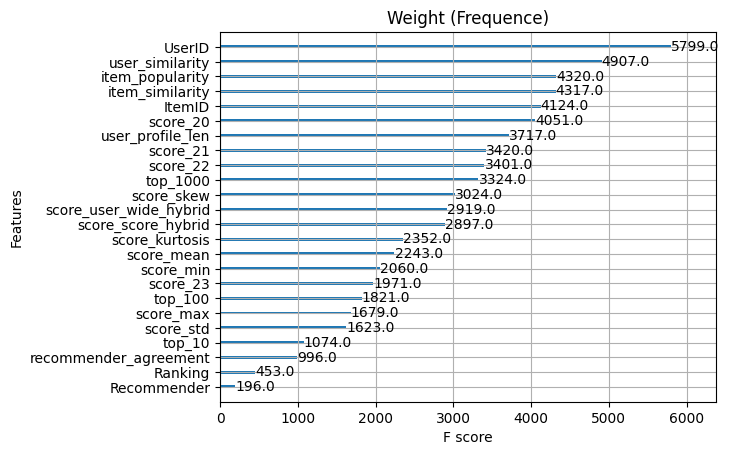

In [34]:
from xgboost import plot_importance

plot_importance(XGB_model, importance_type="weight", title="Weight (Frequence)")

### Model predictions

#### Decode predictions

In [35]:
val_items_dict = decode_targets(X_val, y_val)
len(val_items_dict.keys())

18456

In [36]:
val_predictions_dict = decode_predictions(X_val, XGB_model)
len(val_predictions_dict.keys())

35736

#### Compute recommendation metrics

In [37]:
map_at_k(val_predictions_dict, val_items_dict)

0.08769395100307618

## Hyperparameter optimisation

How to perform hyperparameter tuning?

The issue with this method is that you need a label which should be an item the user has not interacted with but that is a correct recommendation. In practice the idea is:
- Split the data in the usual training-validation-test
- Split the training data in two: one part you use to train the recommenders and another you use as the hidden Label to train XGBoost
- Evaluate your predictions on the validation data as you did for any other recommender model. Use this to select the optimal hyperparameters.
- Given the selected hyperparameters, train the recommender models on all the available data and use all the available data to compute the features used by XGBoost.

Challenge: Since the label we use for training XGBoost is the split of a split, it may happen that the actual correct recommendations are very few. This will result in a problem that is very unbalanced towards zero and will make the training difficult and the evaluation noisy. To mitigate this you may use k-fold cross validation and define the valdation result of a certain hyperparameter configuration as the average obtained with k different training-label splits.

In [20]:
import optuna
from sklearn.model_selection import StratifiedKFold


def objective(trial: optuna.Trial) -> float:
    # Define the hyperparameter search space
    learning_rate = trial.suggest_float("learning_rate", 0.0, 0.3)
    n_estimators = trial.suggest_int("n_estimators", 10, 500)
    max_depth = trial.suggest_int("max_depth", 2, 10)
    l1_regularisation = trial.suggest_float("l1_regularisation", 0.0, 1.0)
    l2_regularisation = trial.suggest_float("l2_regularisation", 0.0, 1.0)
    subsample = trial.suggest_float("subsample", 0.5, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1.0)

    # Initialize the XGBoost model
    model = XGBRanker(
        enable_categorical=True,
        random_state=42,
        objective="rank:pairwise",
        eval_metric="map@10",
        early_stopping_rounds=10,  # Early stopping patience
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        reg_alpha=l1_regularisation,
        reg_lambda=l2_regularisation,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
    )

    # Perform k-fold cross-validation
    kf = StratifiedKFold(n_splits=5)
    scores = []

    for train_idx, val_idx in kf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
        groups_train_fold = X_train_fold.groupby("UserID").size().to_numpy()
        groups_val_fold = X_val_fold.groupby("UserID").size().to_numpy()

        model.fit(
            X_train_fold,
            y_train_fold,
            group=groups_train_fold,
            eval_set=[(X_val_fold, y_val_fold)],
            eval_group=[groups_val_fold],
            verbose=False,
        )
        recommendations = decode_predictions(X_val_fold, model)
        relevant_items = decode_targets(X_val_fold, y_val_fold)
        score = map_at_k(recommendations, relevant_items, k=10)
        scores.append(score)

    return np.mean(scores)


# Run the optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# Get the best hyperparameters
best_params = study.best_params
print("Best parameters:", best_params)

[I 2025-01-04 08:49:22,458] A new study created in memory with name: no-name-177fe6c7-69a3-4cb4-bd33-f6d51fd12855


[I 2025-01-04 08:52:32,263] Trial 0 finished with value: 0.331555167099186 and parameters: {'learning_rate': 0.173343543694998, 'n_estimators': 470, 'max_depth': 3, 'l1_regularisation': 0.9261233493910119, 'l2_regularisation': 0.4494340618101842, 'subsample': 0.5366066089996964, 'colsample_bytree': 0.786856252879855}. Best is trial 0 with value: 0.331555167099186.
[I 2025-01-04 08:55:45,651] Trial 1 finished with value: 0.3285352756367114 and parameters: {'learning_rate': 0.12318439195285222, 'n_estimators': 294, 'max_depth': 3, 'l1_regularisation': 0.4833461157621478, 'l2_regularisation': 0.9166027196530923, 'subsample': 0.7361149844407555, 'colsample_bytree': 0.5043189681676663}. Best is trial 0 with value: 0.331555167099186.
[W 2025-01-04 08:56:24,131] Trial 2 failed with parameters: {'learning_rate': 0.2702747729255557, 'n_estimators': 216, 'max_depth': 3, 'l1_regularisation': 0.7025221264262611, 'l2_regularisation': 0.5457656027369642, 'subsample': 0.6032274572862046, 'colsample_b

KeyboardInterrupt: 

## Submit

In [22]:
submission_dataframe = pd.read_parquet("ranker_submission_data_statistics.parquet")
submission_dataframe

,UserID,ItemID,Recommender,Ranking,recommender_agreement,score_score_hybrid,score_23,score_21,score_22,score_20,...,score_max,score_kurtosis,score_skew,item_popularity,item_similarity,user_profile_len,top_10,top_100,top_1000,user_similarity
0,0,9911,score_hybrid,0,3,0.242614,2.940626,0.226980,0.315740,1.171455,...,2.940626,0.338719,1.397987,27,0.000040,114,0.0,1.0,7.0,0.000183
1,0,14888,score_hybrid,1,5,0.216598,3.389925,0.282408,0.327246,1.195710,...,3.389925,0.561295,1.492638,110,0.000250,114,0.0,1.0,7.0,0.000183
2,0,531,score_hybrid,2,2,0.206871,0.992778,0.126797,0.307062,1.100397,...,1.100397,-1.456910,0.646918,36,0.000225,114,0.0,1.0,7.0,0.000183
3,0,4462,score_hybrid,3,2,0.204848,0.874752,0.136127,0.147709,1.172352,...,1.172352,-1.151668,0.806368,22,0.000303,114,0.0,1.0,7.0,0.000183
4,0,572,score_hybrid,4,5,0.200145,3.708066,0.364245,0.184505,0.906074,...,3.708066,0.922805,1.650838,93,0.000246,114,0.0,1.0,7.0,0.000183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2144155,35735,36775,user_wide_hybrid,5,4,0.238147,8.471791,0.328802,0.358924,2.157352,...,8.471791,0.832299,1.609831,88,0.004034,37,0.0,0.0,0.0,0.000272
2144156,35735,37660,user_wide_hybrid,6,3,0.216601,7.323517,0.347563,0.192113,1.368214,...,7.323517,1.020922,1.696938,70,0.004040,37,0.0,0.0,0.0,0.000272
2144157,35735,36920,user_wide_hybrid,7,4,0.248681,7.601600,0.342447,0.263019,1.772518,...,7.601600,0.903925,1.642833,147,0.003903,37,0.0,0.0,0.0,0.000272
2144158,35735,37017,user_wide_hybrid,8,2,0.222564,4.652850,0.303232,0.303558,2.394336,...,4.652850,-0.268022,1.149794,58,0.003937,37,0.0,0.0,0.0,0.000272


In [28]:
submission_prediction_dict = decode_predictions(
    submission_dataframe[categorical_training_dataframe.columns.drop("Label")],
    XGB_model,
    drop_ids=False,
)
submission_prediction_dict

{35735: [36034, 36493, 37445, 36773, 37657, 37660, 36917, 36920, 36775, 37017],
 35734: [37069, 36168, 36610, 35345, 37067, 37550, 36094, 35093, 37803, 37071],
 35733: [37853, 37388, 37372, 38072, 37540, 36056, 28304, 37858, 28418, 37958],
 35732: [37317, 27644, 38005, 35437, 27590, 37706, 35079, 31350, 34171, 37671],
 35731: [37739, 36263, 35394, 36173, 38027, 37427, 36525, 38049, 28461, 37618],
 35730: [28247, 38027, 37874, 37719, 37739, 33330, 27350, 37118, 37098, 36770],
 35729: [36844, 35548, 26093, 36527, 27531, 37461, 26794, 36566, 38077, 36802],
 35728: [35370, 36665, 35777, 37565, 14090, 28374, 19651, 27510, 27497, 36940],
 35727: [37280, 37291, 27520, 37712, 37416, 28088, 28203, 28097, 14664, 37866],
 35726: [37851, 27768, 37527, 37940, 37740, 28447, 28234, 37653, 38045, 37538],
 35725: [37540, 37431, 28458, 37785, 37924, 36652, 38018, 37661, 38028, 37308],
 35724: [28281, 36504, 27346, 37940, 37178, 26869, 36866, 27689, 38077, 36566],
 35723: [28247, 28461, 36567, 36065, 377

In [29]:
def encode_recommendation(recommendation: list[str]) -> str:
    return " ".join([str(item) for item in recommendation])

In [30]:
test_df["item_list"] = [
    encode_recommendation(recommendation)
    for recommendation in pd.Series(submission_prediction_dict).loc[test_df["user_id"]]
]
test_df

,user_id,item_list
0,0,7547 572 14888 1425 7703 9911 8505 14931 11966...
1,1,6348 13766 14748 13733 11875 11149 15600 18964...
2,2,22714 29656 29964 22589 22625 16255 29963 1938...
3,3,25079 25140 6827 25643 9742 11753 23712 3207 3...
4,4,17624 9812 9447 8612 15902 18304 18647 3454 26...
...,...,...
34226,35729,36844 35548 26093 36527 27531 37461 26794 3656...
34227,35730,28247 38027 37874 37719 37739 33330 27350 3711...
34228,35731,37739 36263 35394 36173 38027 37427 36525 3804...
34229,35734,37069 36168 36610 35345 37067 37550 36094 3509...


In [31]:
test_df.to_csv(SUBMISSION_PATH, index=False)